# Regressão Linear com NumPy

## Objetivos deste experimento

Este exemplo utiliza regressão linear para estimar o comprimento das sépalas da íris a partir do seu comprimento das pétalas.
Utiliza-se programação totalmente NumPy com:
- o **cálculo do gradiente**,
- a **função de perda** e
- a atualização dos parâmetros são feitos de forma explícita.
- A rede é criada com uma camada como uma classe

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLinear_Otimizacao.png)

## Importação dos pacotes

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt   # para plotting

from sklearn.datasets import load_iris  # para carregar dataset

import numpy as np  # processamento matricial

np.random.seed(1234)

## Dataset

### Leitura dos dados

In [41]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_train = data[:,0:1]
y_train = data[:,1:2]

n_samples = x_train.shape[0]
print('x_train.shape:',x_train.shape, x_train.dtype)
print('y_train.shape:',y_train.shape, y_train.dtype)

print('x_train[:5]:\n', x_train[:5])
print('y_train[:5]:\n', y_train[:5])

x_train.shape: (50, 1) float64
y_train.shape: (50, 1) float64
x_train[:5]:
 [[7. ]
 [6.4]
 [6.9]
 [5.5]
 [6.5]]
y_train[:5]:
 [[4.7]
 [4.5]
 [4.9]
 [4. ]
 [4.6]]


### Normalização dos dados

In [42]:
x_train -= x_train.min()
x_train /= x_train.max()
y_train -= y_train.min()
y_train /= y_train.max()

Text(0, 0.5, 'Comprimento petalas')

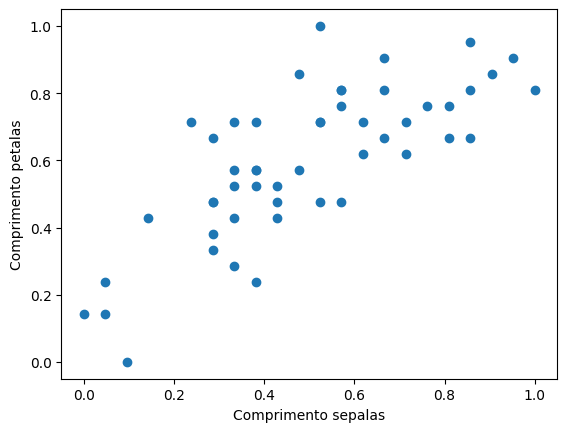

In [43]:
plt.scatter(x_train,y_train)
plt.xlabel('Comprimento sepalas')
plt.ylabel('Comprimento petalas')

## Modelo da rede

### Reta de ajuste

A equação da reta no plano necessita de dois parâmetros, aqui denominados $w_0$ (*bias*) e inclinação $w_1$. Veja figura:

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/linhareta.png)

A reta de ajuste será dada por:

$$ \hat{y} = w_0 + w_1 x $$

onde
* $w_1$ é o coeficiente angular da reta e
* $w_0$ é a interseção do eixo vertical quando x é igual a zero, também denominado de *bias*.
* $x$ é a variável de entrada (comprimento das sépalas) e
* $\hat{y}$ é a predição (comprimento estimado das pétalas).

### Linear Regression Model

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLinearNeuronio.png)

### Formulação matricial do neurônio

* $\mathbf{w} = [w_0 \ w_1]$ é vetor linha de parâmetros e
* $\mathbf{x} = [1 \ x_0] $ é vetor linha de uma amostra (com *bias*).

$$ \hat{y} = 1 w_0 + x_0 w_1 $$

$$ [\hat{y}] = [1 \ x_0] \begin{bmatrix} w_0 \\ w_1 \end{bmatrix} $$

$$ \mathbf{\hat{y}} = \mathbf{x} \mathbf{w^T} $$

### Fazendo o predict de várias amostras

$$ \begin{matrix}
\begin{bmatrix}
\hat{y}_0\\
\hat{y}_1\\
\\
\hat{y}_{M-1}
\end{bmatrix} &=& \begin{bmatrix}
1 & x_0 \\
1 & x_1\\
\\
1 & x_{M-1} \\
\end{bmatrix}
&
\begin{bmatrix}
w_0\\
w_1
\end{bmatrix} \\
(M,1) & & (M,2) & (2,1) \\
\end{matrix} $$

### Preenchendo x com coluna de 1's para bias

In [44]:
x_train_bias = np.hstack([np.ones(shape=(n_samples,1)), x_train])

In [45]:
x_train_bias

array([[1.        , 1.        ],
       [1.        , 0.71428571],
       [1.        , 0.95238095],
       [1.        , 0.28571429],
       [1.        , 0.76190476],
       [1.        , 0.38095238],
       [1.        , 0.66666667],
       [1.        , 0.        ],
       [1.        , 0.80952381],
       [1.        , 0.14285714],
       [1.        , 0.04761905],
       [1.        , 0.47619048],
       [1.        , 0.52380952],
       [1.        , 0.57142857],
       [1.        , 0.33333333],
       [1.        , 0.85714286],
       [1.        , 0.33333333],
       [1.        , 0.42857143],
       [1.        , 0.61904762],
       [1.        , 0.33333333],
       [1.        , 0.47619048],
       [1.        , 0.57142857],
       [1.        , 0.66666667],
       [1.        , 0.57142857],
       [1.        , 0.71428571],
       [1.        , 0.80952381],
       [1.        , 0.9047619 ],
       [1.        , 0.85714286],
       [1.        , 0.52380952],
       [1.        , 0.38095238],
       [1.

### Classe com o modelo da rede

In [46]:
class Net():
    def __init__(self, n_in, n_out):
        self.w = np.random.uniform(-0.1,0.1,(n_out,n_in)) #inicialização dos parâmetros

    def forward(self, x_bias):
        return x_bias.dot(self.w.T)

### Criando a rede, instanciando o objeto model

In [47]:
model = Net(2,1) # duas entradas (1 + x0) e uma saída y_pred

### Testando o predict da rede (mesmo sem treiná-la)

In [48]:
xin = np.random.randn(4,2) # 4 amostras, 2 entradas (1 + x0)
ypred = model.forward(xin)
ypred

array([[-0.09602795],
       [ 0.0661236 ],
       [-0.06857828],
       [-0.05573871]])

## Treinamento via gradiente descendente

Função de perda:
$$ J(\hat{y_i},y_i) = \frac{1}{M} \sum_{i=0}^{M-1} (\hat{y_i} - y_i)^2 $$

Gradiente:
$$  \mathbf{\nabla{J_w}} = \frac{2}{M}\mathbf{x^T}(\mathbf{x w^T} - \mathbf{y}) $$

Atualização dos parâmetros pelo gradiente descendente:
$$ \mathbf{w} = \mathbf{w} − \eta (\mathbf{\nabla J_w})^T $$

### Laço de treinamento

In [49]:
num_epochs = 100
learning_rate = 0.5
for epoch in range(num_epochs):

    # forward - predict
    y_pred = model.forward(x_train_bias)

    #loss cálculo da função de perda
    loss = np.square(y_pred - y_train).mean()

    # cálculo do gradiente pelas derivadas parciais
    w_grad = (2.0/n_samples) * (x_train_bias.T).dot(x_train_bias.dot(model.w.T) - y_train)

    # gradiente descendente
    model.w = model.w - learning_rate * w_grad.T

    # verbose
    if (epoch+1) % 1 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss))

Epoch[1/100], loss: 0.469163
Epoch[2/100], loss: 0.058070
Epoch[3/100], loss: 0.030543
Epoch[4/100], loss: 0.028105
Epoch[5/100], loss: 0.027364
Epoch[6/100], loss: 0.026787
Epoch[7/100], loss: 0.026269
Epoch[8/100], loss: 0.025799
Epoch[9/100], loss: 0.025373
Epoch[10/100], loss: 0.024986
Epoch[11/100], loss: 0.024634
Epoch[12/100], loss: 0.024315
Epoch[13/100], loss: 0.024025
Epoch[14/100], loss: 0.023762
Epoch[15/100], loss: 0.023524
Epoch[16/100], loss: 0.023307
Epoch[17/100], loss: 0.023110
Epoch[18/100], loss: 0.022931
Epoch[19/100], loss: 0.022769
Epoch[20/100], loss: 0.022622
Epoch[21/100], loss: 0.022488
Epoch[22/100], loss: 0.022366
Epoch[23/100], loss: 0.022256
Epoch[24/100], loss: 0.022156
Epoch[25/100], loss: 0.022065
Epoch[26/100], loss: 0.021983
Epoch[27/100], loss: 0.021908
Epoch[28/100], loss: 0.021840
Epoch[29/100], loss: 0.021778
Epoch[30/100], loss: 0.021722
Epoch[31/100], loss: 0.021671
Epoch[32/100], loss: 0.021625
Epoch[33/100], loss: 0.021583
Epoch[34/100], loss

## Avaliação

### Predict

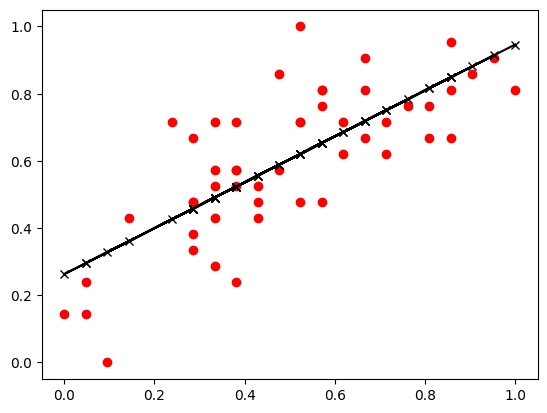

In [50]:
y_pred = model.forward(x_train_bias)
plt.plot(x_train, y_train, 'ro', label='Original data')
plt.plot(x_train, y_pred, 'kx-', label='Fitting Line')

### Parâmetros treinados

In [51]:
print(model.w)

[[0.26295353 0.68335641]]


### Avaliação do modelo

In [52]:
loss = np.square(y_pred - y_train).mean()
loss

0.02117000379151052

### Valor ótimo, solução analítica

$$  \mathbf{w} =(\mathbf{x^T} \mathbf{x})^{−1}\mathbf{x^T} \mathbf{y} $$

In [53]:
x = x_train_bias
y = y_train
w_opt = (np.linalg.inv((x.T).dot(x)).dot(x.T)).dot(y)
print(w_opt.T)

[[0.26134159 0.68646976]]


# Exercícios

## Questões

1. Quantos parâmetros são treinados nesse modelo?

2. Qual é o número de atributos de entrada para a rede?

3. Qual é o número de saídas da rede?

4. Suponha que eu tenha agora 5 mil amostras para fazer a predição. Qual é o shape da matriz de entrada?
   Qual é o shape do matriz de saída?


## Atividades

1. Modifique o laço do treinamento via gradiente descendente para guardar em uma lista, o valor da perda no final
   de cada época. Após o treinamento, plote o valor da perda em função da época.
2. Calcule o valor da perda (MSE) da rede com os parâmetros inicializados, sem serem treinados.
3. Coloque os valores dos pesos da solução ótima analítica no modelo da rede e calcule o valor da perda (MSE) e
   compare com o valor da perda obtida pelo método da otimização via gradiente descendente.

[0.3398312818108879, 0.05068370223997065, 0.031015827060072002, 0.029003172448040945, 0.028209553508144164, 0.027556463693871557, 0.026967922014914967, 0.02643387098874793, 0.02594902380718811, 0.025508831381129093, 0.025109179947633623, 0.02474633568133725, 0.02441690870497431, 0.024117821347284824, 0.023846279385167923, 0.023599745938350677, 0.023375917768568746, 0.02317270376156602, 0.02298820539086344, 0.022820698980778986, 0.022668619602990794, 0.022530546456197294, 0.02240518959228369, 0.022291377864984138, 0.02218804798844993, 0.02209423460350347, 0.02200906125877195, 0.02193173222244208, 0.021861525048137057, 0.02179778382546271, 0.021739913052165816, 0.021687372070655467, 0.0216396700169105, 0.021596361234583333, 0.021557041111456354, 0.021521342299353027, 0.02148893128218829, 0.021459505260095105, 0.021432789320517297, 0.02140853386983948, 0.021386512301559232, 0.021366518879216215, 0.02134836681429973, 0.021331886521177342, 0.021316924032741488, 0.021303339561972036, 0.02129

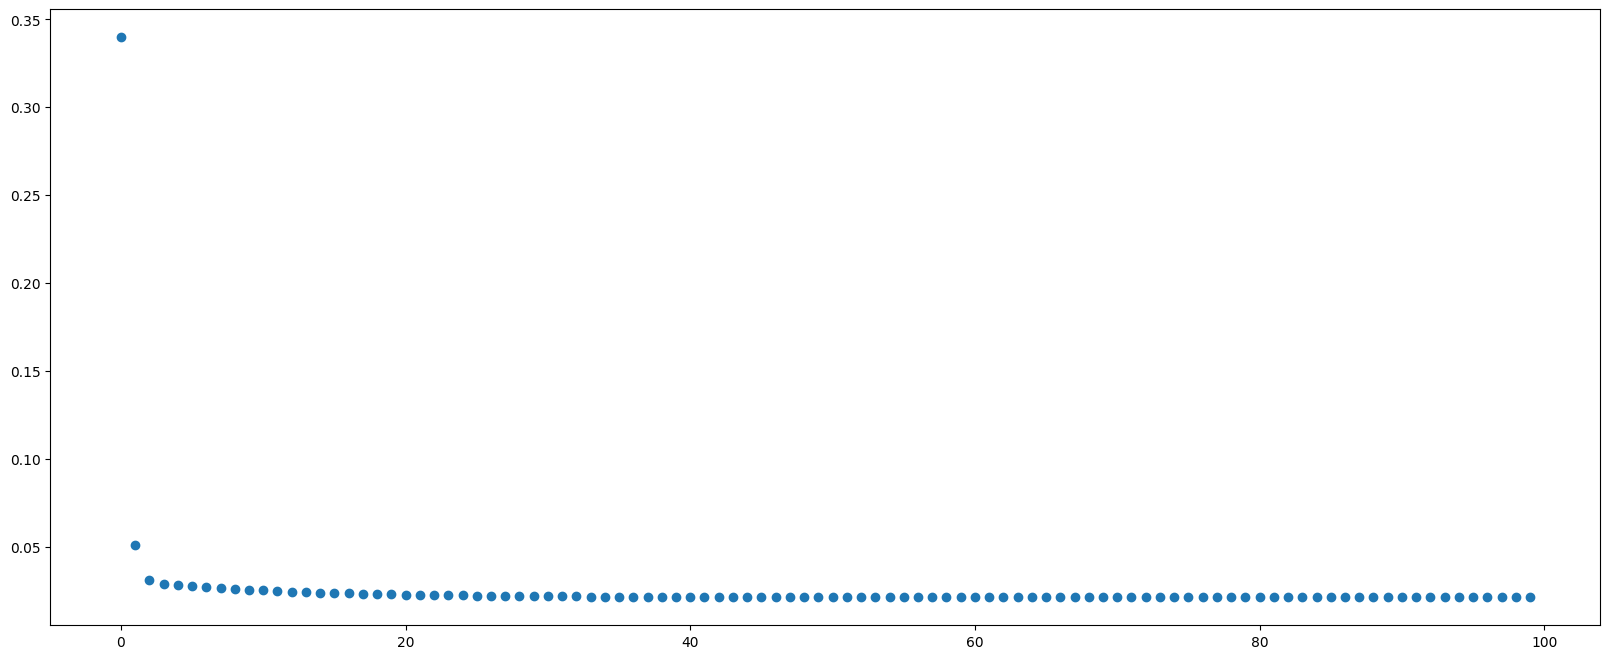

In [54]:
#1
model_1 = Net(2,1)
num_epochs = 100
learning_rate = 0.5

losses = []
for epoch in range(num_epochs):

    # forward - predict
    y_pred = model_1.forward(x_train_bias)

    #loss cálculo da função de perda
    loss = np.square(y_pred - y_train).mean()
    losses.append(loss)

    # cálculo do gradiente pelas derivadas parciais
    w_grad = (2.0/n_samples) * (x_train_bias.T).dot(x_train_bias.dot(model_1.w.T) - y_train)

    # gradiente descendente
    model_1.w = model_1.w - learning_rate * w_grad.T

print(losses)
fig = plt.subplots(figsize = (20, 8))
plt.scatter(range(num_epochs), losses)

In [55]:
#2
model_2 = Net(2,1)
y_pred = model_2.forward(x_train_bias)
loss = np.square(y_pred - y_train).mean()
print(loss)

0.4323749322844236


In [56]:
#3
model_3 = Net(2,1)
x = x_train_bias
y = y_train
w_opt = (np.linalg.inv((x.T).dot(x)).dot(x.T)).dot(y)
#model_3.w = w_opt
model_3.w[0][0] = w_opt[0][0]
model_3.w[0][1] = w_opt[1][0]
y_pred_otima = model_3.forward(x_train_bias)
loss_otima = np.square(y_pred_otima - y_train).mean()
print(f'Perda ótima: {loss_otima}')

y_pred = model.forward(x_train_bias)
loss = np.square(y_pred - y_train).mean()
print(f'Perda treinamento: {loss}')

Perda ótima: 0.021169424119097165
Perda treinamento: 0.02117000379151052


# Aprendizados